In [2]:
import torch, os
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import os
import io
from PIL import Image
import glob

In [3]:
class Net(nn.Module):
    def __init__(self, num_deep_layers=3):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=48, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=5, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        
        self.fc_final = nn.Linear(in_features=256, out_features=33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_final(x)
        
        return x

In [4]:
net = Net()
net.load_state_dict(torch.load(f"models_13/model38.pth"))
if torch.cuda.is_available():
    net = net.cuda()

net.eval()

Net(
  (conv1): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc_final): Linear(in_features=256, out_features=33, bias=True)
)

In [5]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [6]:
def register_hooks():
    model_children = list(net.children())
    model_children[0].register_forward_hook(get_activation('cnn_0'))
    model_children[1].register_forward_hook(get_activation('cnn_1'))
    model_children[2].register_forward_hook(get_activation('cnn_2'))
    model_children[3].register_forward_hook(get_activation('cnn_3'))
register_hooks()

In [7]:
def transform_image(image):
    transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])])
    img_copy = image.copy()
    return transform(img_copy).unsqueeze(0)

In [8]:
files = glob.glob("4/test/*/*")

In [9]:
def get_input_batch(img_path):
    with open(img_path, 'rb') as f:
        image_bytes = f.read()
        image = Image.open(io.BytesIO(image_bytes))
    return transform_image(np.asarray(image))

In [10]:
def get_layer_output(layer_name, filter_idx):
    return activation[layer_name][0,filter_idx,:,:].cpu().numpy()

In [11]:
def get_norm_of_mat(mat):
    return np.linalg.norm(mat)

In [19]:
def get_norm_of_cnn_output_of_img(file,layer_name,filter_idx):
    input_batch = get_input_batch(file)
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
    activation = {}
    with torch.no_grad():
        output = net(input_batch)
    layer_output = get_layer_output(layer_name,filter_idx)
    norm = get_norm_of_mat(layer_output)
    return norm

In [20]:
def get_num_filters(layer_name):
    return activation[layer_name][0,:,:,:].size(dim=0)

In [21]:
def plot_all_filters(layer_name):
    dimensi_iter = get_num_filters(layer_name)
    for i in range(dimensi_iter):
        im2 = plt.imshow(activation[layer_name][0,i,:,:].cpu().numpy(), cmap="Greys", alpha=.9, interpolation='bilinear')
        plt.colorbar()
        plt.savefig(f'feature_map/{layer_name}_{i}.png')
        plt.close()

In [22]:
def plot_particular_filter(layer_name, filter_idx):
    im2 = plt.imshow(activation[layer_name][0,filter_idx,:,:].cpu().numpy(), cmap="Greys", alpha=.9, interpolation='bilinear')
    plt.colorbar()
    plt.savefig(f'feature_map/{layer_name}_{layer_idx}.png')
    plt.close()

In [23]:
def get_top_5_inputs(layer_name, filter_idx):
    file_to_norm_map = {}
    for f in tqdm(files):
        norm = get_norm_of_cnn_output_of_img(f, layer_name, filter_idx)
        file_to_norm_map[f] = norm
    sorted_map = {k: v for k, v in sorted(file_to_norm_map.items(), key=lambda item: item[1], reverse=True)}
    sorted_files = list(sorted_map.keys())
    return sorted_files[:5]

In [24]:
def generate_plot(file, layer_name, filter_idx):
    def read_img(file):
        with open(file, 'rb') as f:
            image_bytes = f.read()
            image = Image.open(io.BytesIO(image_bytes))
        return np.asarray(image)
    label = file.split("/")[2]
    get_norm_of_cnn_output_of_img(file, layer_name, filter_idx)
    print(f"Label of the following image: {label}")
    f, axarr = plt.subplots(1,2, figsize=(14,7))
    axarr[0].imshow(activation[layer_name][0,filter_idx,:,:].cpu().numpy(), cmap="Greys", alpha=.9, interpolation='bilinear')
    axarr[1].imshow(read_img(file))

In [30]:
def generate_plot_multiple(layer_name, filter_idx):
    files = get_top_5_inputs(layer_name, filter_idx)
    def read_img(file):
        with open(file, 'rb') as f:
            image_bytes = f.read()
            image = Image.open(io.BytesIO(image_bytes))
        return np.asarray(image)
    f, axarr = plt.subplots(5,2, figsize=(10,25))
    for i,file in enumerate(files):
        label = file.split("/")[2]
        get_norm_of_cnn_output_of_img(file, layer_name, filter_idx)
        #print(f"Label of the following image: {label}")
        axarr[i,0].imshow(activation[layer_name][0,filter_idx,:,:].cpu().numpy(), cmap="Greys", alpha=.9, interpolation='bilinear')
        axarr[i,1].imshow(read_img(file))

100%|██████████| 3300/3300 [00:09<00:00, 361.67it/s]


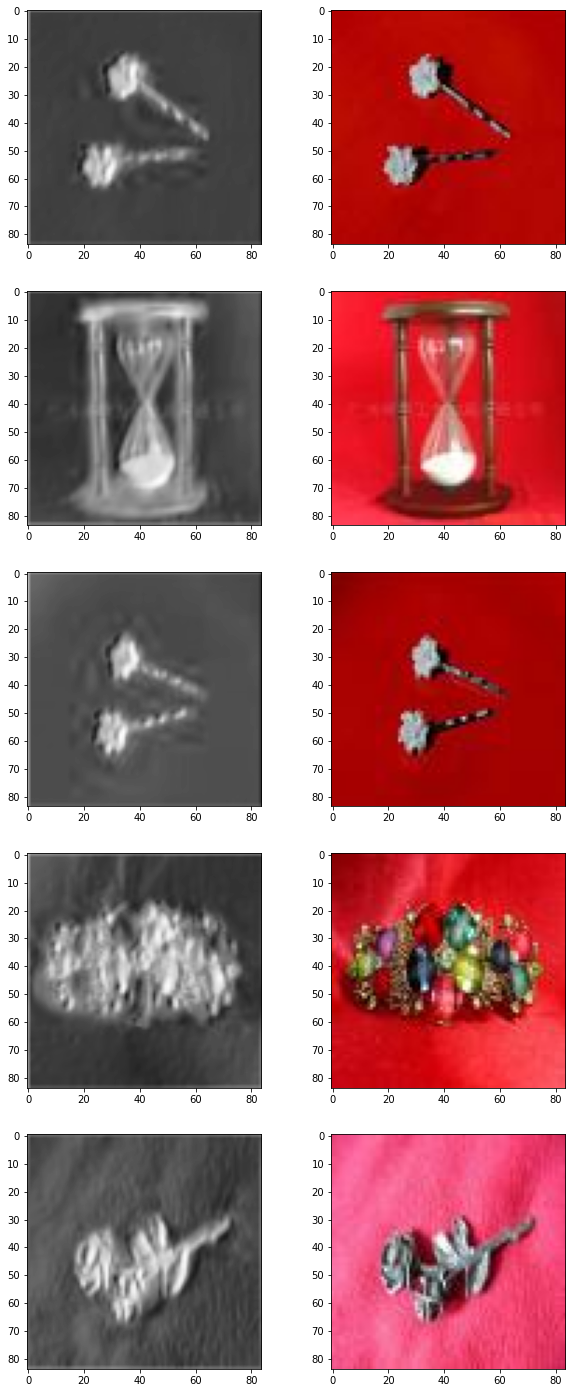

In [32]:
generate_plot_multiple("cnn_0", 0)

100%|██████████| 3300/3300 [00:09<00:00, 344.31it/s]


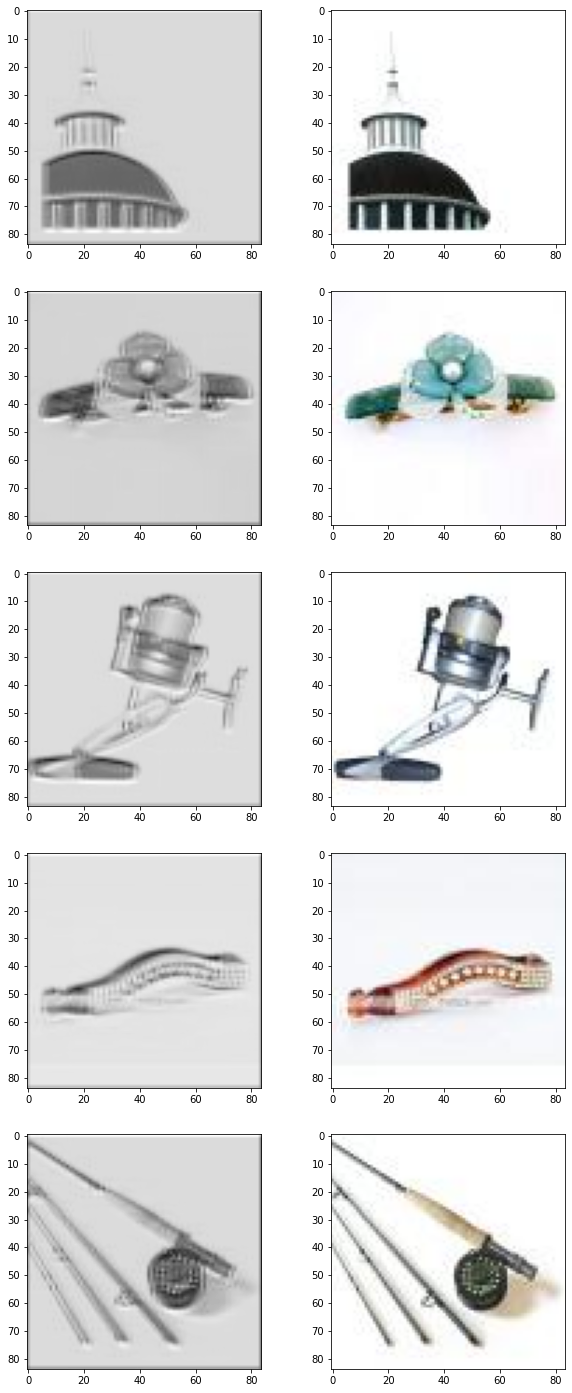

In [33]:
generate_plot_multiple("cnn_0", 4)

100%|██████████| 3300/3300 [00:09<00:00, 358.86it/s]


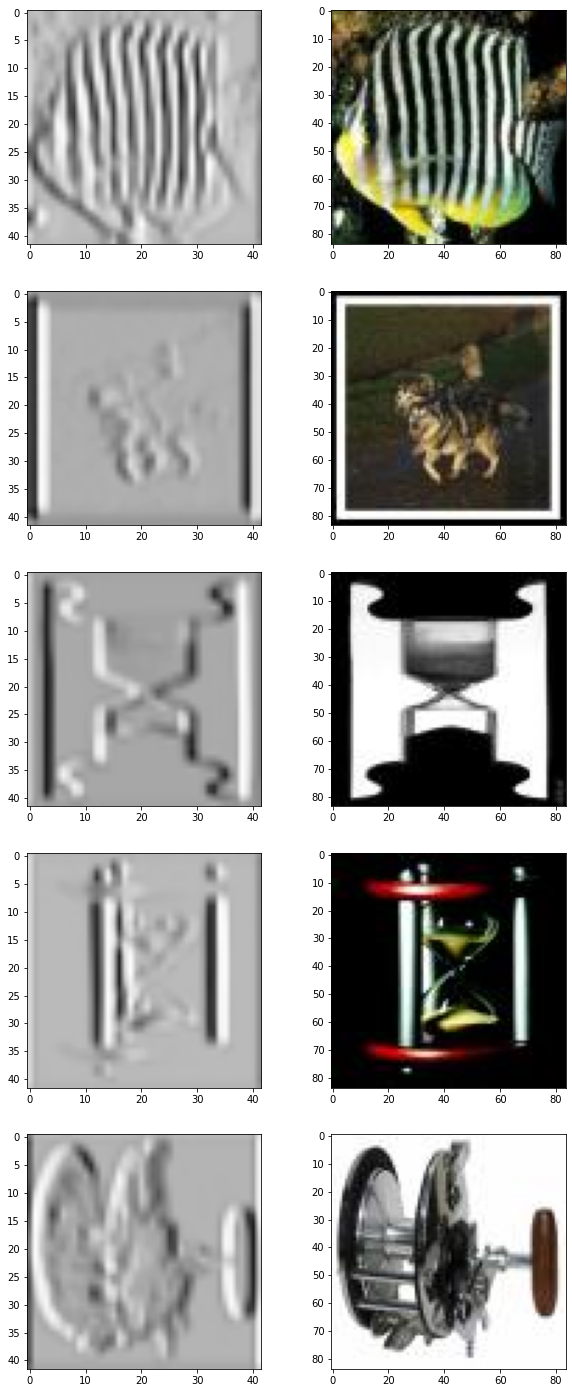

In [34]:
generate_plot_multiple("cnn_1", 13)

100%|██████████| 3300/3300 [00:09<00:00, 361.30it/s]


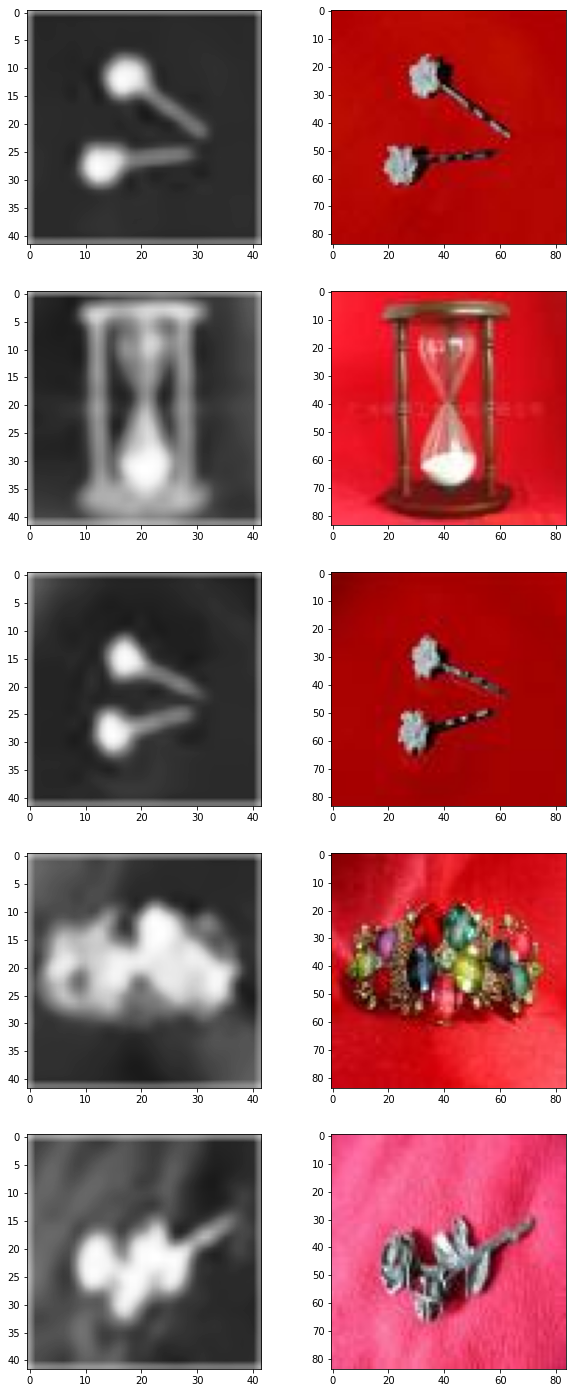

In [35]:
generate_plot_multiple("cnn_1", 28)

100%|██████████| 3300/3300 [00:09<00:00, 357.79it/s]


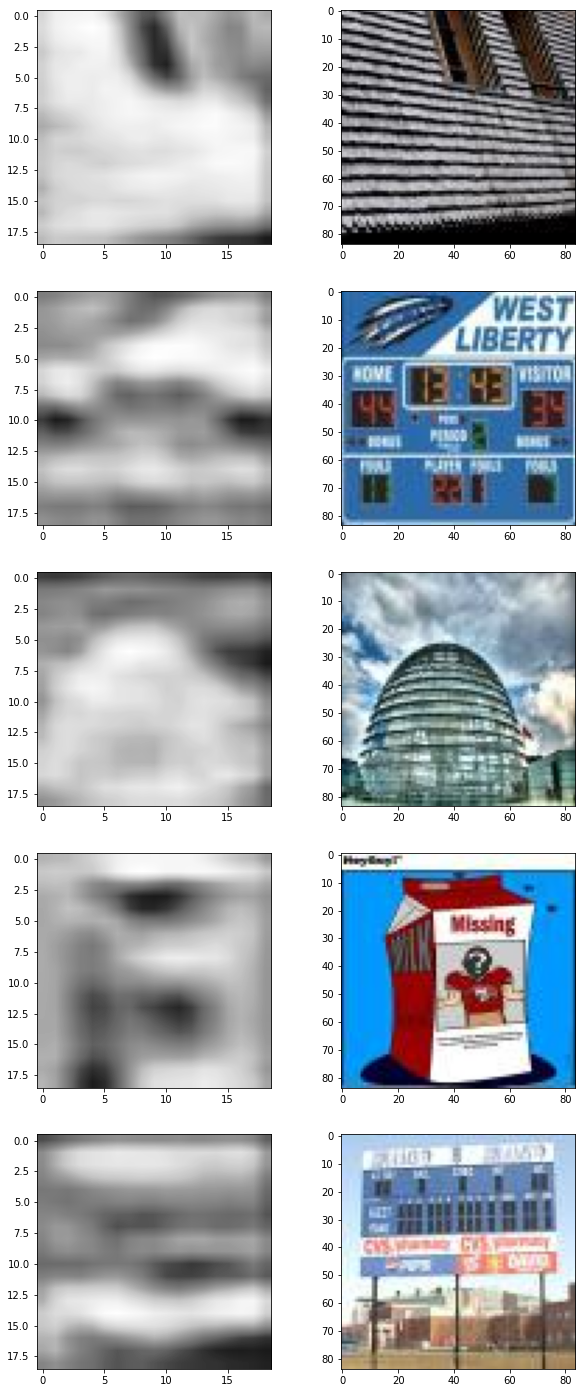

In [36]:
generate_plot_multiple("cnn_2", 19)

100%|██████████| 3300/3300 [00:09<00:00, 358.94it/s]


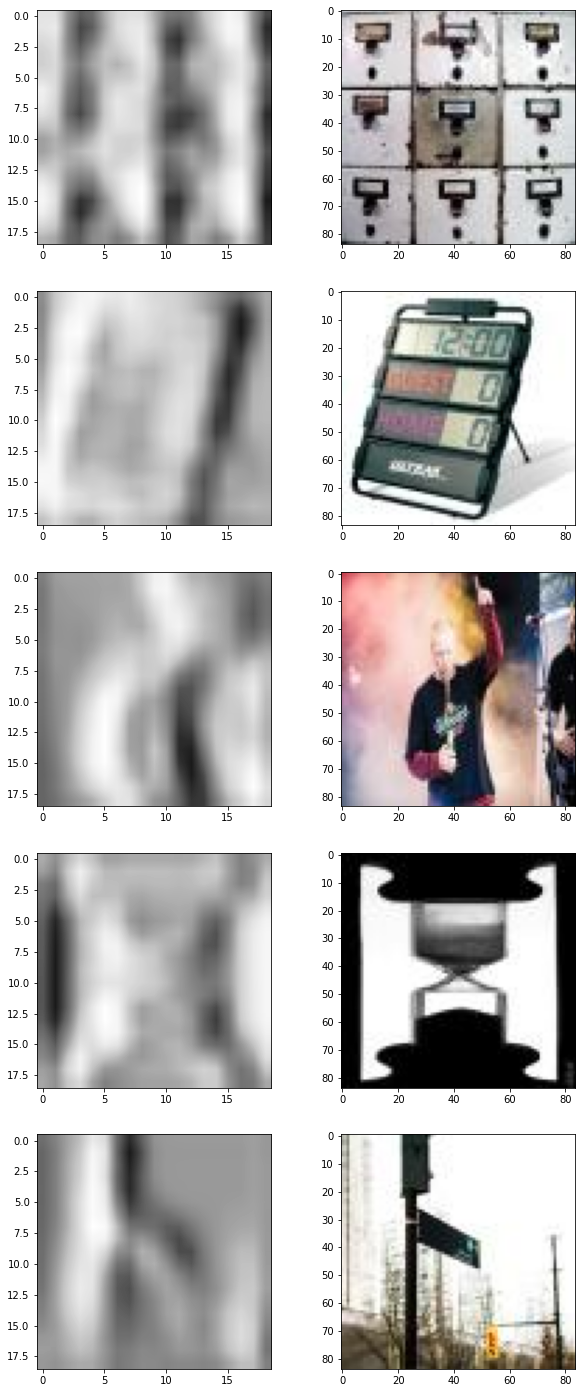

In [37]:
generate_plot_multiple("cnn_2", 3)

100%|██████████| 3300/3300 [00:09<00:00, 363.40it/s]


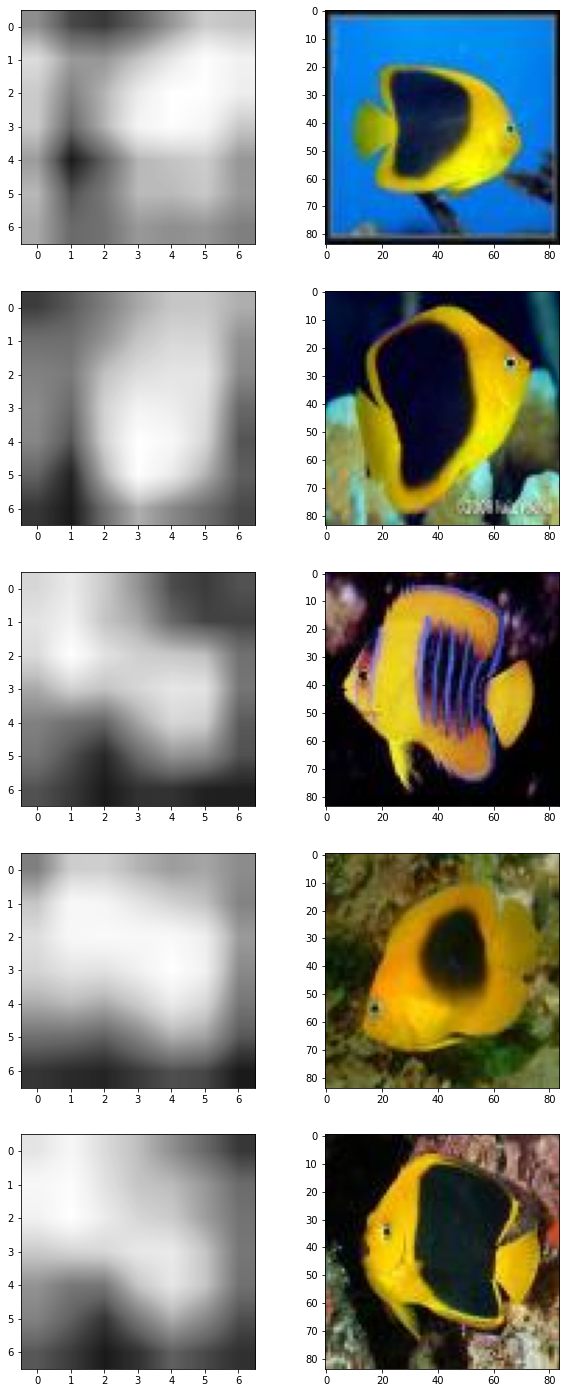

In [39]:
generate_plot_multiple("cnn_3", 14)

100%|██████████| 3300/3300 [00:09<00:00, 358.77it/s]


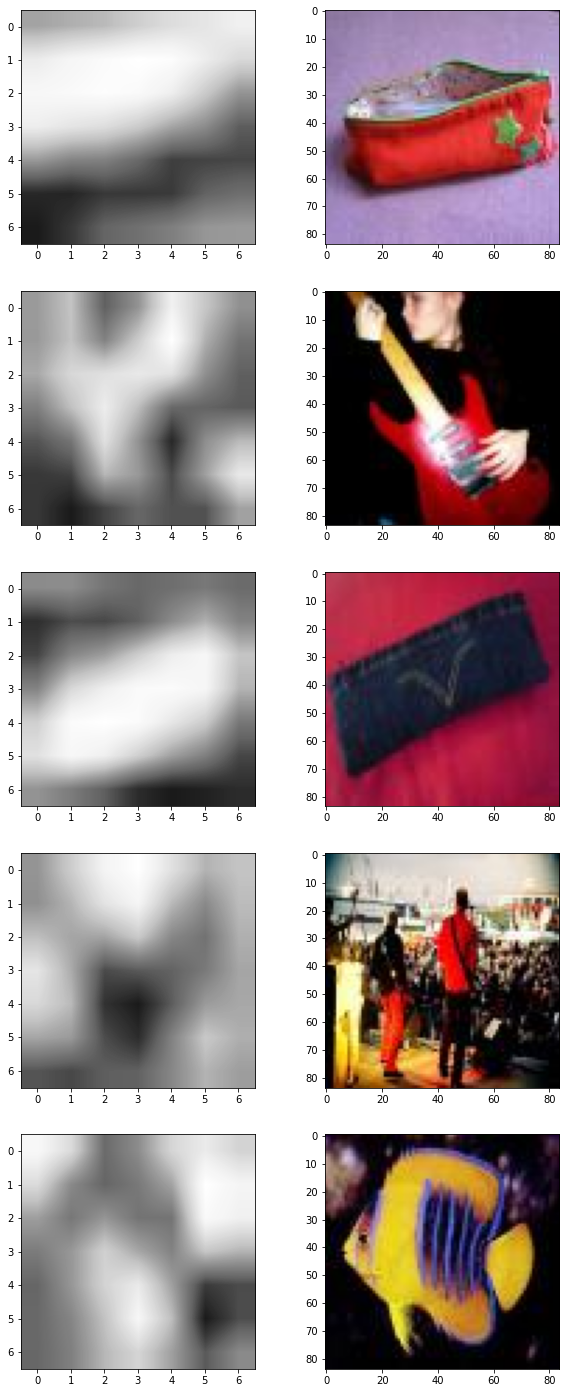

In [40]:
generate_plot_multiple("cnn_3", 19)

100%|██████████| 3300/3300 [00:09<00:00, 348.87it/s]


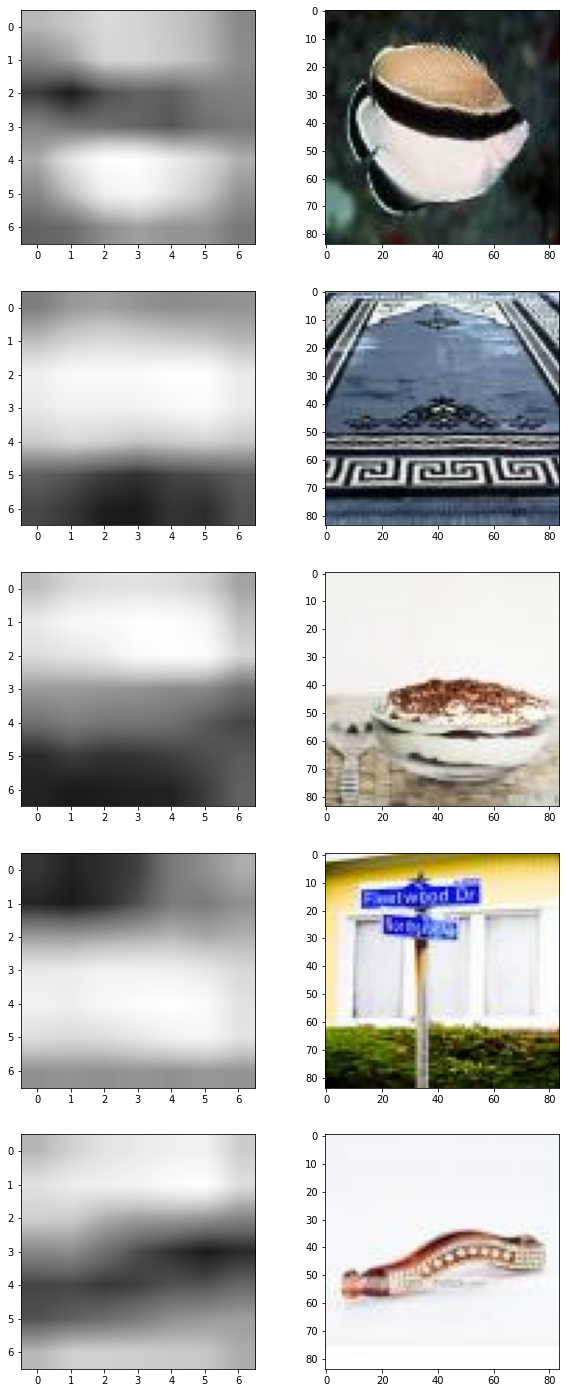

In [41]:
generate_plot_multiple("cnn_3", 21)

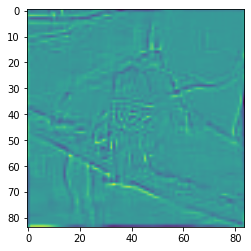

In [166]:
act = activation["cnn_0"][0,0,:,:].cpu().numpy()
plt.imshow(act, cmap=plt.cm.viridis, alpha=.9, interpolation='bilinear')

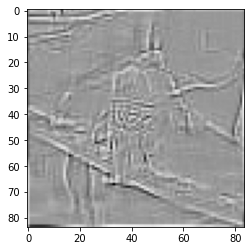

In [167]:
new_arr = ((act - act.min()) * (1/(act.max() - act.min()) * 255)).astype('uint8')
plt.clf()
plt.imshow(new_arr, cmap="Greys")